# **Libraries**

In [1]:
!pip install pydot

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from kaggle_datasets import KaggleDatasets

from IPython.display import FileLink

2024-10-30 02:21:47.461341: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-30 02:21:47.461449: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-30 02:21:47.626382: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import PIL

In [5]:
import shutil

# **Configure processor use**
Use TPU, GPU, or CPU, in that order, based on availability.

In [6]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
        if tf.config.list_physical_devices('GPU'):
            strategy = tf.distribute.MirroredStrategy()
            print("Running on GPU.")
        else:
            strategy = tf.distribute.get_strategy()
            print("Running on CPU.")

print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

Running on GPU.
Number of replicas: 1
2.15.0


# **Data**

In [7]:
GCS_PATH = KaggleDatasets().get_gcs_path()

In [8]:
MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


In [9]:
IMAGE_SIZE = [256, 256] # Size according to info on the competition page

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

In [10]:
# Function to extract the images
def load_dataset(filenames):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls = AUTOTUNE)
    return dataset

In [11]:
# Load the data sets
monet_ds = load_dataset(MONET_FILENAMES) # .batch(1) # Try with 2, 4, and 8 too.
photo_ds = load_dataset(PHOTO_FILENAMES) # .batch(1) # Try with 2, 4, and 8 too.

In [12]:
%%time 

# Check the number of images in each data set
monet_count = 0
for _ in monet_ds:
    monet_count += 1

print(f"Number of images in monet_ds: {monet_count}")

photo_count = 0
for _ in photo_ds:
    photo_count += 1

print(f"Number of images in photo_ds: {photo_count}")

Number of images in monet_ds: 300
Number of images in photo_ds: 7038
CPU times: user 11 s, sys: 1.68 s, total: 12.6 s
Wall time: 18.2 s


In [13]:
# Shuffle the images
monet_ds = monet_ds.shuffle(buffer_size = monet_count)
photo_ds = photo_ds.shuffle(buffer_size = photo_count)

# **Take a portion of the images**
To speed up early testing of the code, select just a portion of the data.

In [14]:
# How much of the data to use
portion = 0.02

# Calculate number of batches
monet_count_to_use = int(monet_count * portion)
photo_count_to_use = int(photo_count * portion)

# Take a portion of the datasets
monet_ds = monet_ds.take(monet_count_to_use)
photo_ds = photo_ds.take(photo_count_to_use)

# **Batch the images**

In [15]:
# Batch the images
monet_ds = monet_ds.batch(1)
photo_ds = photo_ds.batch(1)

# **Exploratory Data Analysis**

## **Check number of photos and Monets**

Is this needed as a sanity check?

In [16]:
MONET_JPG = tf.io.gfile.glob(str(GCS_PATH + '/monet_jpg/*.jpg'))
PHOTO_JPG = tf.io.gfile.glob(str(GCS_PATH + '/photo_jpg/*.jpg')) 

# Display number of files in Monet and Photo directories
print('Number of images in Monet directory: ', len(MONET_JPG))
print('Number of images in photo directory: ', len(PHOTO_JPG))

Number of images in Monet directory:  300
Number of images in photo directory:  7038


## **Show 5 photos and 5 Monets**

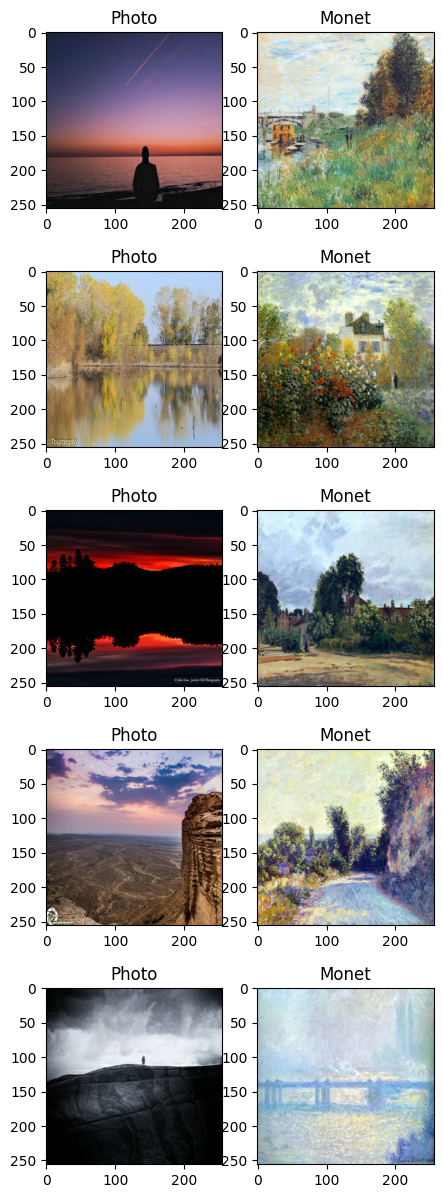

In [17]:
# Create iterables from the datasets
monet_iter = iter(monet_ds)
photo_iter = iter(photo_ds)

# Set up a grid of 5 rows and 2 columns
fig, axes = plt.subplots(5, 2, figsize = (5, 15))

# Display 5 pairs of images
for i in range(5):
    photo = next(photo_iter)
    monet = next(monet_iter)
    
    axes[i][0].imshow(photo[0] * 0.5 + 0.5)
    axes[i][0].set_title("Photo")
    
    axes[i][1].imshow(monet[0] * 0.5 + 0.5)
    axes[i][1].set_title("Monet")
    

# **Generator**

## **Encoder: downsample**

In [18]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean = 0.0, stddev = 0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides = 2, padding = 'same',
                             kernel_initializer = initializer, use_bias = False))

    if apply_instancenorm:
        result.add(tf.keras.layers.GroupNormalization(gamma_initializer = gamma_init, groups = -1))

    result.add(layers.LeakyReLU())

    return result

## **Decoder: upsample**

In [19]:
def upsample(filters, size, apply_dropout = False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean = 0.0, stddev = 0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides = 2,
                                      padding = 'same',
                                      kernel_initializer = initializer,
                                      use_bias = False))

    result.add(tf.keras.layers.GroupNormalization(gamma_initializer = gamma_init, groups = -1))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

## **Generator**
The generator downsamples the input image and then upsample and establishes skip connections. Skip connections preserves image information and help bypass the vanishing gradient problem by concatenating the output of a layer to multiple layers. 

In [20]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

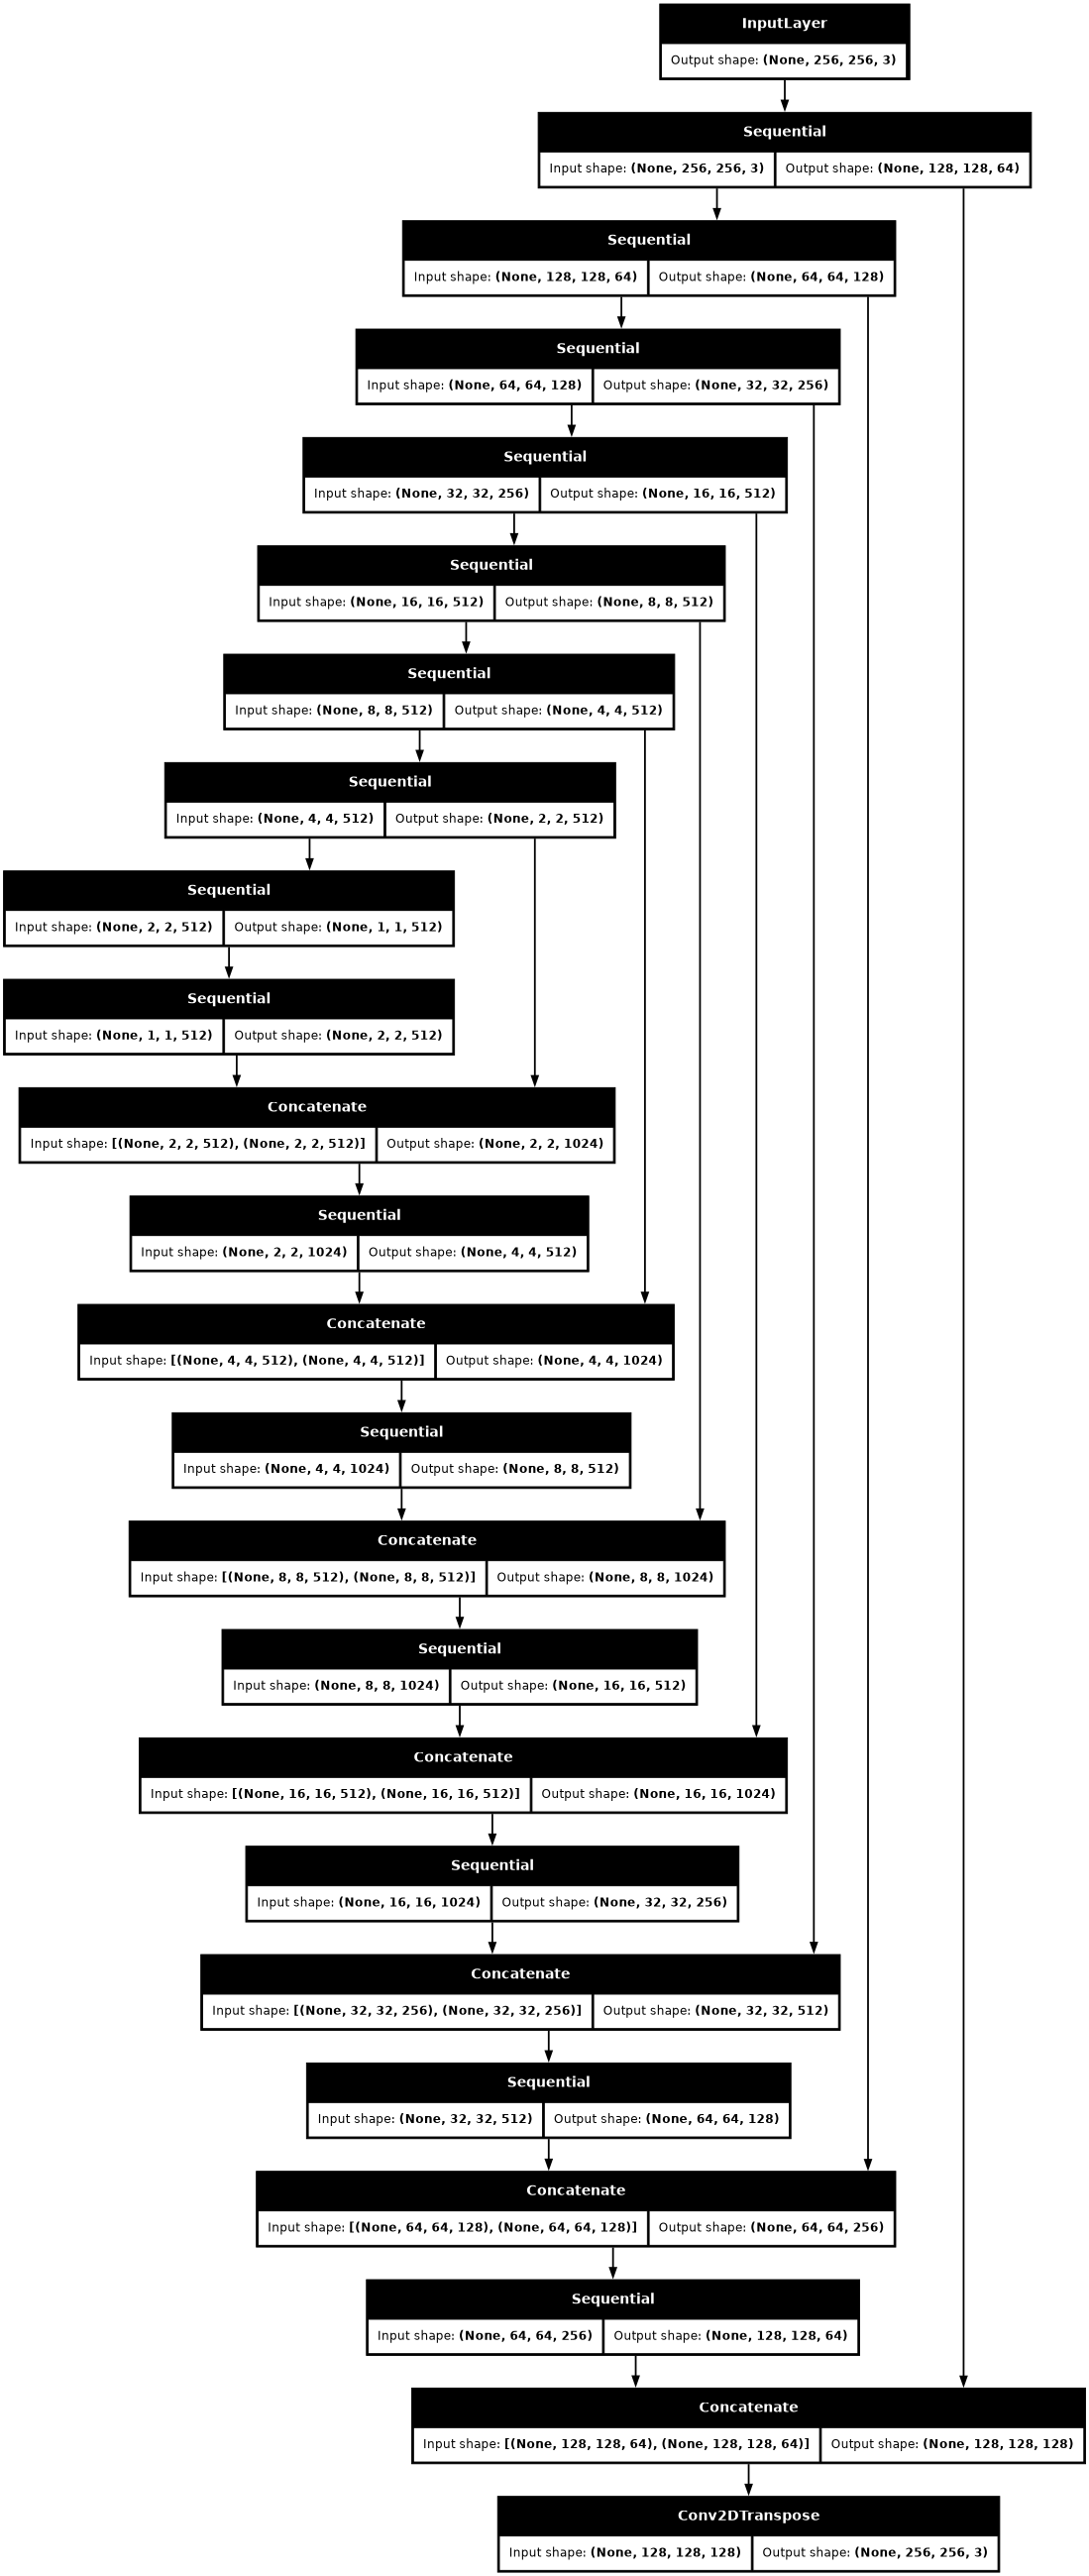

In [21]:
# Create a generator
generator = Generator()

# Vislualize the generator architecture
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

# **Discriminator**

The discriminator classifies the image as real or generated.

In [22]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean = 0.0, stddev = 0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = tf.keras.layers.GroupNormalization(gamma_initializer = gamma_init, groups = -1)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs = inp, outputs = last)

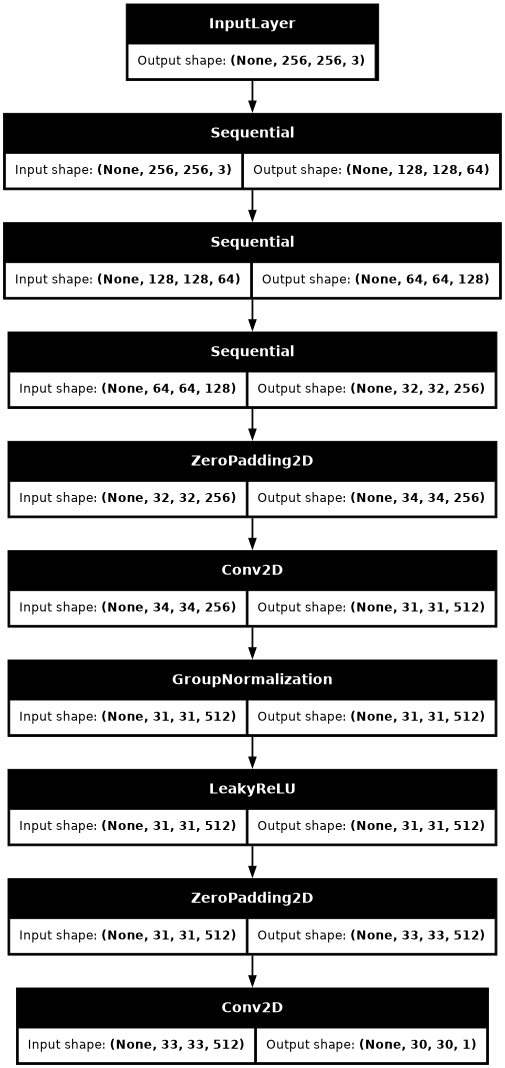

In [23]:
# Create a discriminator
discriminator = Discriminator()

# Visualize the discriminator architecture
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

In [24]:
with strategy.scope():
    monet_generator = Generator() # Transforms photos to Monet-esque paintings
    photo_generator = Generator() # Transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # Differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # Differentiates real photos and generated photos

# **CycleGAN model**

In [25]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

# **Loss functions**
Loss functions for the generator, discriminator, cycle consistency, and identity.

In [26]:
# Generator loss function
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [27]:
# Discriminator loss function
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

In [28]:
# Cycle consistency loss function
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

In [29]:
# Identity loss function
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

# **Train the model**

## **Optimizers**

In [30]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## **Model instantiation**

In [31]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

## **Train the model**

In [32]:
%%time

cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs = 10 # Try 25 and 50
)

Epoch 1/10


2024-10-30 02:23:30.627403: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/gradient_tape/functional_35_5/sequential_28_1/dropout_5_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


6/6 ━━━━━━━━━━━━━━━━━━━━ 78s 298ms/step - monet_disc_loss: 0.6885 - monet_gen_loss: 10.6036 - photo_disc_loss: 0.6871 - photo_gen_loss: 11.3079
Epoch 2/10


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 292ms/step - monet_disc_loss: 0.6745 - monet_gen_loss: 12.3077 - photo_disc_loss: 0.6693 - photo_gen_loss: 12.9413
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 291ms/step - monet_disc_loss: 0.6705 - monet_gen_loss: 10.4372 - photo_disc_loss: 0.6611 - photo_gen_loss: 10.7751
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 292ms/step - monet_disc_loss: 0.6607 - monet_gen_loss: 9.8439 - photo_disc_loss: 0.6502 - photo_gen_loss: 10.4169
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 303ms/step - monet_disc_loss: 0.6559 - monet_gen_loss: 7.9519 - photo_disc_loss: 0.6512 - photo_gen_loss: 8.2774
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 295ms/step - monet_disc_loss: 0.6332 - monet_gen_loss: 5.9054 - photo_disc_loss: 0.6356 - photo_gen_loss: 6.1846
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 293ms/step - monet_disc_loss: 0.6618 - monet_gen_loss: 5.1802 - photo_disc_loss: 0.6204 - photo_gen_loss: 5.3668
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 293ms/step - monet_disc_loss: 0.6255 - monet_gen

## **Use our trained model to generate Monet-like images**

In [33]:
directory = '/kaggle/working/images'
if not os.path.exists(directory):
    os.makedirs(directory)

In [34]:
%%time

# Generate fake Monets
i = 1
for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("/kaggle/working/images/" + str(i) + ".jpg")
    i += 1

CPU times: user 20.5 s, sys: 3.95 s, total: 24.5 s
Wall time: 23.3 s


In [35]:
# Put the fake Monets in a zip file
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'

In [36]:
# Generate a download link
filename = 'images.zip'
FileLink(rf'{filename}')

/kaggle/working/images.zip